In [28]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [4]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2024-07-04 04:25:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.115.207, 142.250.114.207, 142.251.116.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.115.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.1MB/s    in 8.0s    

2024-07-04 04:25:40 (20.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [3]:
import os
import pathlib
import numpy as np

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

data_dir = pathlib.Path('10_food_classes_10_percent/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/test".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/steak".
There are 0 directories and 250 images in "10_food_classes_10_percent

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 244)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## TensorBoard Callbacks

In [5]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## TensorFlow Hub

In [6]:
import tensorflow_hub as hub


def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

In [9]:
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

efficientnet_model = create_model(efficientnet_url,
                                num_classes=train_data.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

EPOCHS = 5

efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficient_netb0')])


Saving TensorBoard log files to: tensorflow_hub/efficient_netb0/20240707-040429
Epoch 1/5


2024-07-07 04:04:36.502335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-07-07 04:04:37.341119: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f60d8b770d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-07 04:04:37.341154: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-07 04:04:37.345968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720325077.419003     737 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 35s 1s/step - loss: 1.7893 - accuracy: 0.4707 - val_loss: 1.2804 - val_accuracy: 0.7468
Epoch 2/5
24/24 [==============================] - 13s 572ms/step - loss: 1.0359 - accuracy: 0.8160 - val_loss: 0.8535 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 13s 546ms/step - loss: 0.7409 - accuracy: 0.8533 - val_loss: 0.6858 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 13s 575ms/step - loss: 0.5967 - accuracy: 0.8747 - val_loss: 0.6009 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 13s 578ms/step - loss: 0.5081 - accuracy: 0.8960 - val_loss: 0.5522 - val_accuracy: 0.8656


In [10]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


<Axes: >

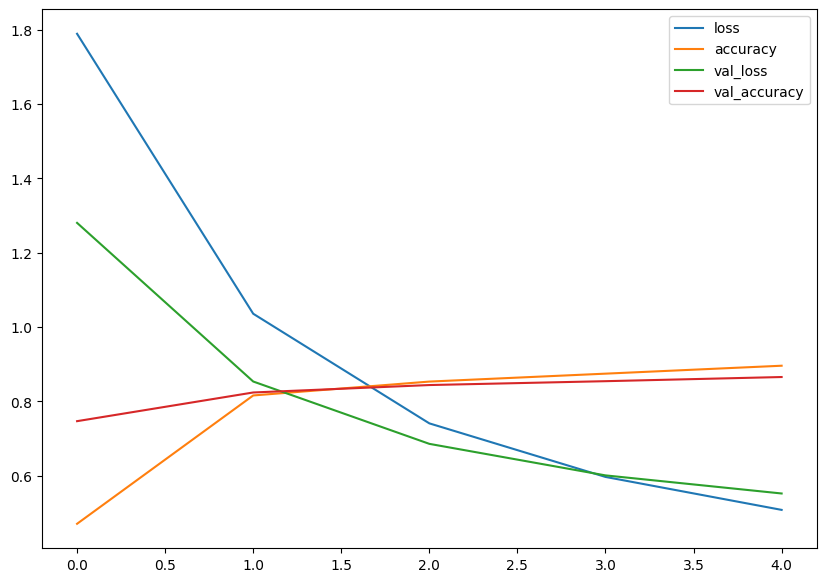

In [11]:
import pandas as pd

pd.DataFrame(efficientnet_history.history).plot(figsize=(10,7))